# 1D NLSE Solver

The goal of this notebook is to solve the Nonlinear Shrodinger Equation in 1D:
\begin{equation}
    \frac{\partial A}{\partial z} = -i\frac{\beta_2}{2} \frac{\partial^2 A}{\partial t^2} + i\gamma |A|^2 A.
\end{equation}
The first term of RHS corresponds to the chromatic dispersion, where $\beta_2$ is group velocity dispersion, and the second term is Kerr nonlinearity. 

This can be solved numerically using split-step Fourier method:
\begin{equation}
    A(z + \Delta z, T) = \mathcal{F}^{-1}\left\{ e^{i\frac{\beta_2}{2} (\omega)^2 \Delta z}  \cdot   \mathcal{F} \left\{   e^{i \gamma |A(z, T)|^2 \Delta z}   A(z, T) \right\}  \right\} 
\end{equation}

In [2]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import os


# torch imports
import torch
import torch.nn.functional as F
import torch.optim as optim

In [3]:
torch.set_default_dtype(torch.float32)

In [4]:
# update the matplotlib configuration parameters:
plt.rcParams.update({'font.size': 14})
# fix OpenMP Environemnt Error
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

### Define Operations

In [5]:
def dispersion_operator(beta2, dt, Nt, dz):
    """Calculate the dispersion operator for the linear step in Fourier space using PyTorch."""
    omega = 2 * torch.pi * torch.fft.fftfreq(Nt, dt)
    return torch.exp(0.5j * beta2 * omega**2 * dz)

def nonlinear_operator(gamma, A, dz):
    """Apply the nonlinear operator for the nonlinear step in real space using PyTorch."""
    return A * torch.exp(1j * gamma * torch.abs(A)**2 * dz)

def split_step_fourier(A0, dz, Nz, beta2, gamma, Lt):
    """Implement the Split-Step Fourier Method using PyTorch."""
    A = A0.clone()
    Nt = len(A)
    dt = Lt / Nt
    linear_op = dispersion_operator(beta2, dt, Nt, dz)
    A_evolution = torch.zeros((Nt, Nz+1), dtype=torch.complex64)
    A_evolution[:, 0] = A0 # set first column of A_evolution to be the initial pulse

    for i in range(Nz):
        A = nonlinear_operator(gamma, A, dz) # apply nonlinear operator
        A_ft = torch.fft.fft(A) # transform to Fourier space
        A_ft *= linear_op # apply linear operator
        A = torch.fft.ifft(A_ft) # transform back to real space
        
        A_evolution[:, i+1] = A

    return A_evolution

In [6]:
# other useful functions
def time_derivative_fft(A, Nt, Lt):
    dt = Lt / Nt
    N = A.shape[-1]  # Number of time points
    # Fourier Transform
    fft_A = torch.fft.fft(A.detach())
    frequencies = torch.fft.fftfreq(N, d=dt)  # Frequency bins
    omega = 2 * torch.pi * frequencies  # Angular frequency
    # Compute derivative in frequency domain
    fft_dA_dt = 1j * omega * fft_A
    # Inverse Fourier Transform
    dA_dt = torch.fft.ifft(fft_dA_dt).real
    return dA_dt

# get second time derivative
def time_second_derivative_fft(A, Nt, Lt):
    dt = Lt / Nt
    N = A.shape[-1]  # Number of time points
    # Fourier Transform
    fft_A = torch.fft.fft(A.detach())
    frequencies = torch.fft.fftfreq(N, d=dt)  # Frequency bins
    omega = 2 * torch.pi * frequencies  # Angular frequency
    # Compute derivative in frequency domain
    fft_d2A_dt2 = -omega**2 * fft_A
    # Inverse Fourier Transform
    d2A_dt2 = torch.fft.ifft(fft_d2A_dt2).real
    return d2A_dt2

In [7]:
# useful functions for plotting
def plot_intensity_evolution(intensity_evolution, t, Lz, Nz):
    """Plot the intensity evolution in 3D using PyTorch."""
    # # convert to umpy representations for plotting
    intensity_evolution = intensity_evolution.detach().numpy().T
    t = t.detach().numpy()
    z = torch.linspace(0, Lz, Nz+1).detach().numpy()
    
    T, Z = np.meshgrid(t, z)
    
    
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot_surface(T, Z, intensity_evolution, cmap='viridis', edgecolor='none') # intensity_evolution.T is the intensity matrix (transposed to match dimensions) - Z value
    ax.set_xlabel('Time (ps)')
    ax.set_ylabel('z (km)')
    ax.set_zlabel('Intensity |A|^2')
    ax.set_title('Intensity Evolution in NLSE')
    plt.show()
    
def plot_spectrum(A0, Nt, Lt):
    """Plot the spectrum of the initial pulse."""
    dt = Lt / Nt
    freq = torch.fft.fftfreq(Nt, dt)
    freq_shifted = torch.fft.fftshift(freq)
    A0_ft = torch.fft.fft(A0)
    A0_ft_shifted = torch.fft.fftshift(A0_ft)
    plt.figure(figsize=(10, 5))
    plt.plot(freq_shifted.detach().numpy(), torch.abs(A0_ft_shifted.detach()).numpy())
    plt.title('Spectrum of the Pulse')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Intensity')
    plt.show()
    
def plot_spectrum_comparison(input, output, Nt, Lt):
    """Plot the spectrum of the initial pulse and the output pulse for comparison."""
    # detach the tensors
    dt = Lt / Nt
    freq = torch.fft.fftfreq(Nt, dt)
    freq_shifted = torch.fft.fftshift(freq)
    input_ft = torch.fft.fft(input.detach())
    input_ft_shifted = torch.fft.fftshift(input_ft)
    output_ft = torch.fft.fft(output.detach())
    output_ft_shifted = torch.fft.fftshift(output_ft)
    plt.figure(figsize=(10, 5))
    plt.plot(freq_shifted, torch.abs(input_ft_shifted).numpy(), label='Input')
    plt.plot(freq_shifted, torch.abs(output_ft_shifted).numpy(), label='Output')
    plt.title('Spectrum of the Pulse')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()
    
def simulate_and_plot(A0, dz, Nz, beta2, gamma, Lt):
    """Simulate the NLSE using the Split-Step Fourier Method and plot the intensity evolution."""
    A_evolution = split_step_fourier(A0, dz, Nz, beta2, gamma, Lt)
    t = torch.linspace(0, Lt, len(A0))
    plot_intensity_evolution(torch.abs(A_evolution)**2, t, Nz*dz, Nz)

def plot_time_derivative(A0, Nt, Lt):
    """Plot the time derivative of the pulse."""
    t = torch.linspace(0, Lt, Nt)
    dA_dt = time_derivative_fft(A0, Nt, Lt)
    plt.figure(figsize=(10, 5))
    plt.plot(t, dA_dt, color = "m")
    plt.title('Time Derivative of the Pulse')
    plt.xlabel('Time')
    plt.ylabel('dA/dt')
    plt.grid()
    plt.show()
    
def plot_second_time_derivative(A0, Nt, Lt):
    """Plot the second time derivative of the pulse."""
    t = torch.linspace(0, Lt, Nt)
    d2A_dt2 = time_second_derivative_fft(A0, Nt, Lt)
    plt.figure(figsize=(10, 5))
    plt.plot(t, d2A_dt2, color = "m")
    plt.title('Second Time Derivative of the Pulse')
    plt.xlabel('Time')
    plt.ylabel('d^2A/dt^2')
    plt.grid()
    plt.show()

def plot_temporal_waveform(z_plot_list, A_evolution, t, Lz, Nz):
    plt.figure(figsize=(10, 5))
    for z_plot in z_plot_list: 
        index = int(z_plot / Lz * Nz)
        plt.plot(t.numpy(), torch.abs(A_evolution[:, index])**2, label='z= %.f' % z_plot)
    plt.title('Intensity Waveform')
    plt.xlabel('Time')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()
    

## Autodifferentiation
We have 3 distinct inputs:
1) Initial Waveform (which itself could be parametrized w.r.t. inputs)
2) $\beta_2$ - dispersion property of medium
3) $\gamma$ - nonlinearity property of medium

### Gaussian Pulse

First, consider a simple example of a Gaussian pulse, with the incident field of the form
\begin{equation}
    A(z,0) = \sqrt{P_0} e^{ - t^2/2 T_0^2},
\end{equation}
where $P_0$ is the peak power, $T_0$ is the width of the incident pulse.

In [8]:
def gaussian_pulse(t, center, T0, P0):
    """Generate a Gaussian pulse using PyTorch."""
    return torch.sqrt(torch.tensor(P0)) * torch.exp(-((t - center) ** 2) / (2 * T0 ** 2))

In [9]:
# define the simulation parameters
Lz = 20.0               # Propagation distance in km
Nz = 1000               # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 300.0               # Temporal window size
Nt = 1024               # Number of temporal points

# define medium parameters
beta2 = 20         # Dispersion coefficient in ps^2/km
gamma = 2          # Nonlinearity coefficient in W^-1 km^-1

### Example Case 1 - Derivative w.r.t time $t$ of initial Gaussian Pulse $A(0,t)$

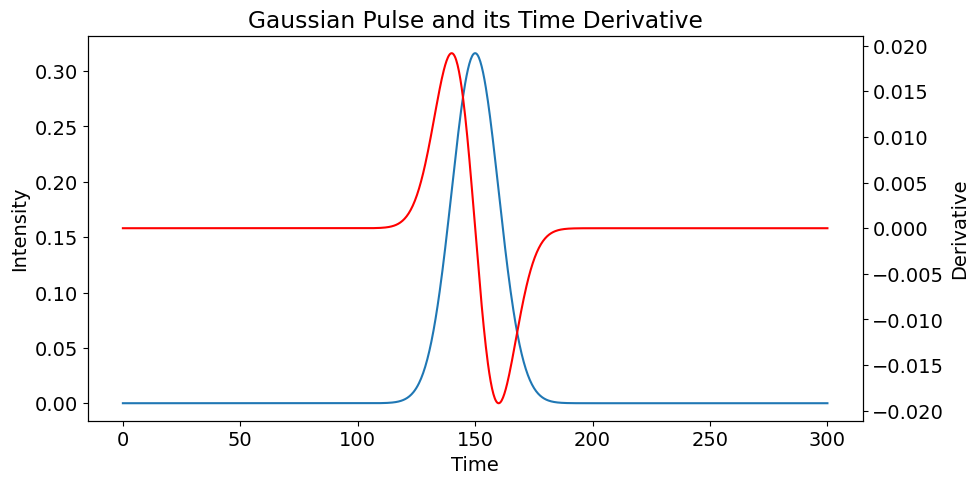

In [10]:
# constants
center = Lt / 2         # Center of the Gaussian pulse
T0 = 10.0             # Width of the Gaussian pulse on ps
P0 = 0.1                # sqrt of the peak power of the Gaussian pulse

# independent variable (we use torch for automatic differentiation)
t = torch.linspace(0, Lt, Nt, requires_grad=True)  # Temporal grid (only positive times)

# generate the Gaussian pulse
A0 = gaussian_pulse(t, center, T0, P0)

# find derivative
A0.sum().backward() # propagate the gradient
dA0_dt = t.grad

# plot the Gaussian pulse and its derivative on stister twinx plots
plt.figure(figsize=(10, 5))
plt.plot(t.detach().numpy(), A0.detach().numpy(), label='Intensity')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.twinx()
plt.plot(t.detach().numpy(), dA0_dt, 'r', label='Derivative')
plt.ylabel('Derivative')
plt.title('Gaussian Pulse and its Time Derivative')
plt.show()




### Example Case 2 - Derivative w.r.t square root of power $\sqrt{P_0}$ of final Gaussian $I(z,t_{end})$ after SSFM evolution

In [11]:
def gaussian_pulse(t, center, T0, P0):
    """Generate a Gaussian pulse using PyTorch."""
    return torch.sqrt(P0) * torch.exp(-((t - center) ** 2) / (2 * T0 ** 2)) # recast P0 as tensor to ensure gradient flow

In [12]:
# constants
center = Lt / 2         # Center of the Gaussian pulse
T0 = 10.0             # Width of the Gaussian pulse on ps
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)

# independent variable (we use torch for automatic differentiation)
P0 = torch.tensor(0.1, requires_grad=True) 

# Initial condition
A0 = gaussian_pulse(t, center, T0, P0)

# Perform the split-step Fourier method
A_evolution = split_step_fourier(A0, dz, Nz, beta2, gamma, Lt)
intensity_evolution = torch.abs( A_evolution )**2

Iend = intensity_evolution[-1, :]

#Iend.sum().backward()
#dIend_dP0 = P0.grad

# alternative method
dIend_dP0_alt = torch.autograd.grad(intensity_evolution[-1, :].sum(), P0)[0]

In [13]:
#print(dIend_dP0)
print(dIend_dP0_alt)

tensor(0.0953)


## Optimal Waveform Finding
In the following scenarios we try to find optimized waveforms (or equivalently various waveform parameters) to minimize the amplitude change as a pulse passes through a fiber.


### Scenario 1: Optimizing $T_0$ - Width Parameter for sech() Pulse

When $\beta_2<0$, the effects from dispersion term and nonlinear term can cancel out, preseving the shape of the propgating pulse.

The fundamental soliton pulse has the sech shape
\begin{equation}
    A_s(z,t) = A_0 sech( \frac{t}{T_0} ) e^{-i\frac{\beta_2}{2T_0^2} z}.
\end{equation}

In order to have a soliton, we need to ensure the effects from nonlinear term and the dispersion term balance out exactly, satisfying
\begin{equation}
    \gamma = - \frac{\beta_2}{T_0^2 A_0^2}.
\end{equation}

Keeping $\gamma$, $\beta_t$, and $A_0$ constant we then expect the optimal width value to be 
\begin{equation}
    T_0 = \sqrt{-\frac{\beta_2}{\gamma A_0^2}}.
\end{equation}


1. Define the Parametrization of the pulse

In [14]:
# define pulse
def sech_pulse(t, center, T0, A0):
    """Generate a Gaussian pulse."""
    
    return A0* 1/torch.cosh( (t-center)/ T0 + 1e-16) + 1e-16

# define simulation parameters
Lz = 20.0               # Propagation distance in km
Nz = 100              # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 300              # Temporal window size
Nt = 1024               # Number of temporal points
t = torch.linspace(0, Lt, Nt, requires_grad=False)  # Temporal grid (only positive times)

# define pulse parameters
center = Lt / 2         # Center of the Gaussian pulse
T0 = torch.tensor(13.0, requires_grad=True)            # Width of the Gaussian pulse on ps
A0 = 0.1                # sqrt of the peak power of the Gaussian pulse

# define medium parameters
beta2 = -20           # Dispersion coefficient in ps^2/km
gamma = 20

print("The optimal value of T0 would be:", np.sqrt(-(beta2)/(gamma*A0**2)))

The optimal value of T0 would be: 10.0


In [16]:
""" Side estimate - energy of pulse"""
# get intensity
intensity = torch.abs(sech_pulse(t, center, T0, A0))**2
# get energy
energy = torch.trapz(intensity, t)

print("The energy of the pulse is:", energy.item())

The energy of the pulse is: 0.2600000202655792


2. Define our model / forward pass (our operations)

In [13]:
def forward(Ain):
    # Perform the split-step Fourier method
    A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)
    return A_evolution[:, -1]
    

3. Define our loss (to minimize)

In [14]:
def loss_function(Ain, Aout):
    # return the mean squared error
    return F.mse_loss(torch.abs(Ain)**2, torch.abs(Aout)**2)

4. Set up the optimizer

In [15]:
optimizer = optim.Adam([T0], lr=1e-2)

4. Train our "model"

In [16]:
N_train = 1000

# define list to store losses
losses = []
params = []

Debugging

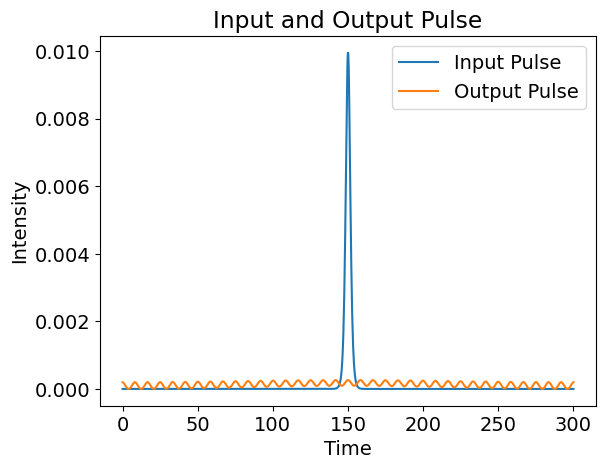

In [17]:
# Compute the sech_pulse output
pulse = sech_pulse(t, center, 2, A0)

#print(pulse)

out = forward(pulse)

# plit input pulse and output
plt.plot(t.detach().numpy(), (torch.abs(pulse)**2).detach().numpy(), label='Input Pulse')
plt.plot(t.detach().numpy(), (torch.abs(out)**2).detach().numpy(), label='Output Pulse')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.title('Input and Output Pulse')
plt.show()




# # Compute the derivative of the sum of the output w.r.t. T0
# pulse.sum().backward()  # Backpropagate the gradient
# print(f"Derivative of sech_pulse w.r.t. T0: {T0.grad}")

# # plot the pulse
# plt.plot(t.detach().numpy(), pulse.detach().numpy())
# plt.xlabel('Time')
# plt.ylabel('Intensity')
# plt.title('Sech Pulse')
# plt.show()


Iteration 0, Loss: 2.1851180918019963e-06
Iteration 10, Loss: 2.06736058316892e-06
Iteration 20, Loss: 1.9503513613017276e-06
Iteration 30, Loss: 1.8345524495089194e-06
Iteration 40, Loss: 1.7204127971126582e-06
Iteration 50, Loss: 1.6084260323623312e-06
Iteration 60, Loss: 1.499023596807092e-06
Iteration 70, Loss: 1.3926403426012257e-06
Iteration 80, Loss: 1.2896888392788242e-06
Iteration 90, Loss: 1.1905124210898066e-06
Iteration 100, Loss: 1.0954190656775609e-06
Iteration 110, Loss: 1.0046898069049348e-06
Iteration 120, Loss: 9.185164913105837e-07
Iteration 130, Loss: 8.370685691261315e-07
Iteration 140, Loss: 7.604346592415823e-07
Iteration 150, Loss: 6.886736514388758e-07
Iteration 160, Loss: 6.217811687747599e-07
Iteration 170, Loss: 5.597046310867881e-07
Iteration 180, Loss: 5.023395033276756e-07
Iteration 190, Loss: 4.495633163514867e-07
Iteration 200, Loss: 4.0119954292094917e-07
Iteration 210, Loss: 3.570654314444255e-07
Iteration 220, Loss: 3.169340629938233e-07
Iteration 23

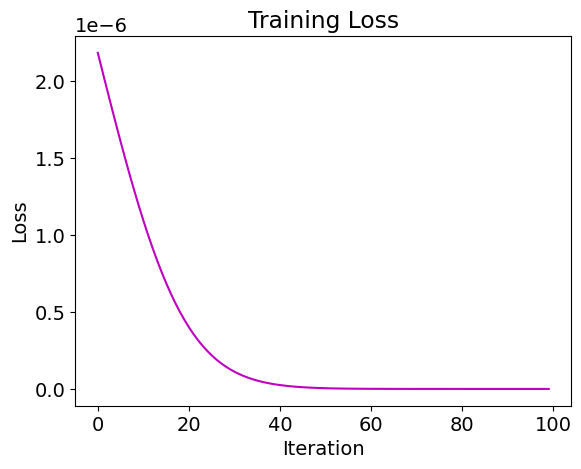

In [18]:
# Training loop
for iter in range(N_train):
    # clear gradients from previous step
    optimizer.zero_grad()  

    # compute output and loss
    Ain = sech_pulse(t, center, T0, A0)  # generate the input pulse
    Aout = forward(Ain)  # full forward pass
    
    loss = loss_function(Ain, Aout)  # calculate the loss

    # backpropagate the loss
    loss.backward()

    # print the gradient of T0# if gradient is nan break the loop
    if torch.isnan(T0.grad):
        print("Gradient is NaN. Exiting the loop.")
        break
    
    # update the parameters
    optimizer.step()

    # save and print the loss every 100 iteration
    if iter % 10 == 0:
        losses.append(loss.item())
        params.append(T0.item())
        print(f"Iteration {iter}, Loss: {loss.item()}")

# plot the loss
plt.plot(losses, color='m')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

Show results

In [19]:
print("The optimal value of T0 would be:", T0.item())

The optimal value of T0 would be: 10.004164695739746


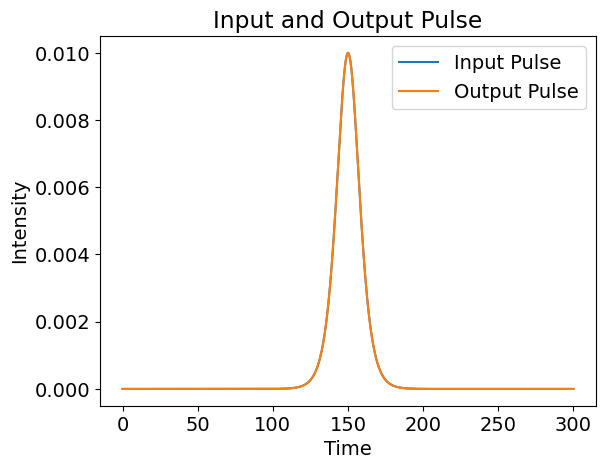

In [20]:
# Compute the sech_pulse output
pulse = sech_pulse(t, center, T0, A0)
out = forward(pulse)

# plit input pulse and output
plt.plot(t.detach().numpy(), (torch.abs(pulse)**2).detach().numpy(), label='Input Pulse')
plt.plot(t.detach().numpy(), (torch.abs(out)**2).detach().numpy(), label='Output Pulse')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.title('Input and Output Pulse')
plt.show()

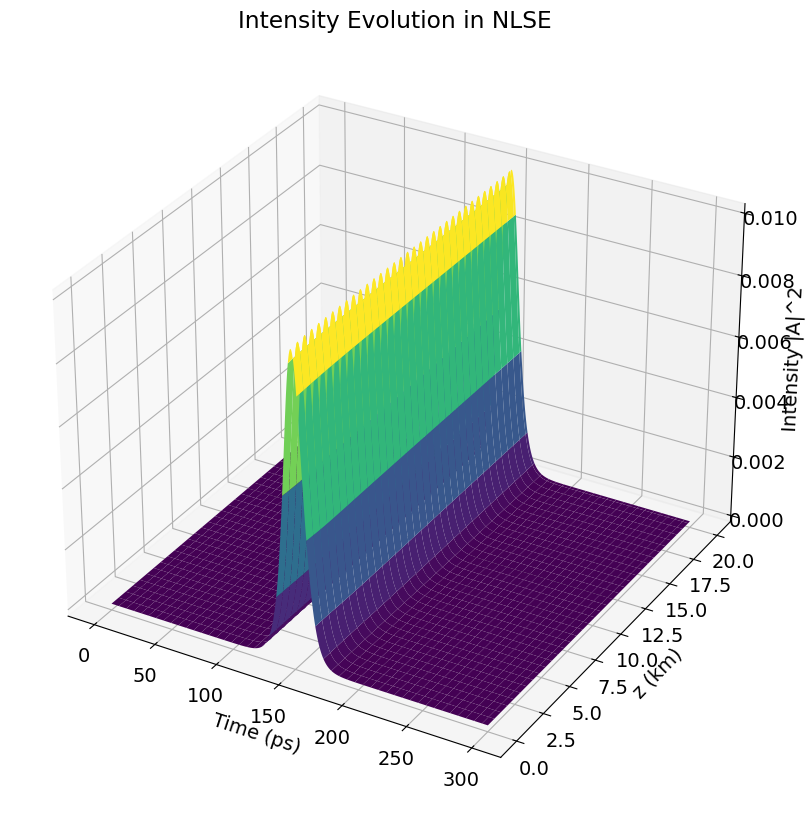

In [21]:
# plot the evolution of optimized input pulse
pulse = sech_pulse(t, center, T0, A0)

simulate_and_plot(pulse, dz, Nz, beta2, gamma, Lt)

Plot loss space

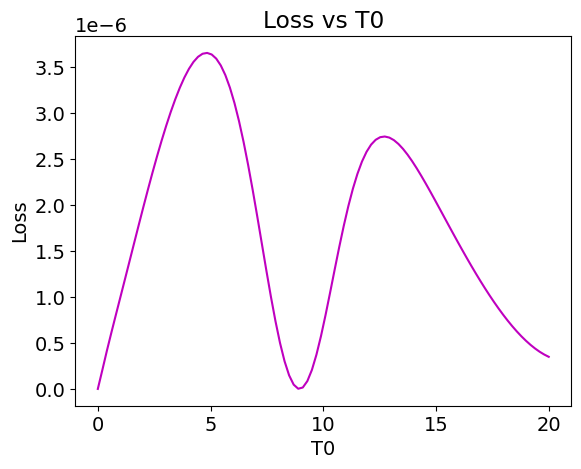

In [27]:

t0 = torch.linspace(0, 20, 100)
losses = []

for T0 in t0:
    out = forward(sech_pulse(t, center, T0, A0))
    loss = loss_function(sech_pulse(t, center, T0, A0), out)
    losses.append(loss.item())



plt.plot(t0, losses, color='m')
plt.xlabel('T0')
plt.ylabel('Loss')
plt.title('Loss vs T0')
plt.show()




### Scenario 2: Optimizing $A_0$ - Width Parameter for sech() Pulse

As before the fundamental soliton pulse has the sech shape
\begin{equation}
    A_s(z,t) = A_0 sech( \frac{t}{T_0} ) e^{-i\frac{\beta_2}{2T_0^2} z}.
\end{equation}

In order to have a soliton, we need to ensure the effects from nonlinear term and the dispersion term balance out exactly, satisfying
\begin{equation}
    \gamma = - \frac{\beta_2}{T_0^2 A_0^2}.
\end{equation}

Keeping $\gamma$, $\beta_t$, and $T_0$ constant we then expect the optimal amplitude value to be 
\begin{equation}
    A_0 = \sqrt{-\frac{\beta_2}{\gamma T_0^2}}.
\end{equation}


In [28]:
# define pulse
def sech_pulse(t, center, T0, A0):
    """Generate a Gaussian pulse."""
    
    return A0* 1/torch.cosh( (t-center)/ T0 + 1e-16) + 1e-16

# define simulation parameters
Lz = 20.0               # Propagation distance in km
Nz = 100              # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 300              # Temporal window size
Nt = 1024               # Number of temporal points
t = torch.linspace(0, Lt, Nt, requires_grad=False)  # Temporal grid (only positive times)

# define pulse parameters
center = Lt / 2         # Center of the Gaussian pulse
A0 = torch.tensor(0.112, requires_grad=True)            # Width of the Gaussian pulse on ps
T0 = 10                # sqrt of the peak power of the Gaussian pulse

# define medium parameters
beta2 = -20           # Dispersion coefficient in ps^2/km
gamma = 20

print("The optimal value of A0 would be:", np.sqrt(-(beta2)/(gamma*T0**2)))

The optimal value of A0 would be: 0.1


In [29]:
# define the forward run
def forward(Ain):
    # Perform the split-step Fourier method
    A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)
    return A_evolution[:, -1]

# define the loss function
def loss_function(Ain, Aout):
    # return the mean squared error
    return F.mse_loss(torch.abs(Ain)**2, torch.abs(Aout)**2)

# set up the optimizer
optimizer = optim.Adam([A0], lr=1e-3)

Debugging

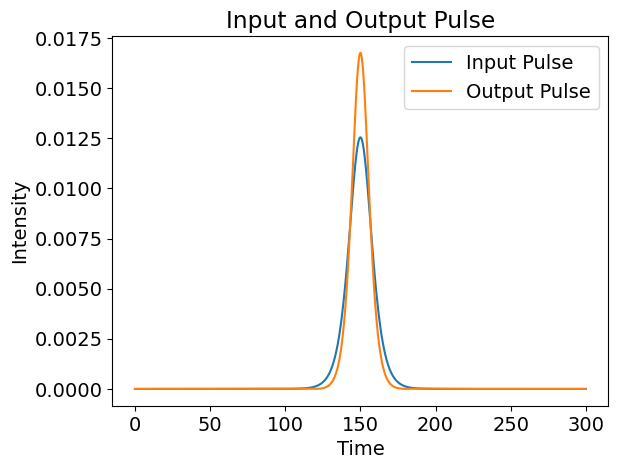

Derivative of sech_pulse w.r.t. T0: 107.12823486328125


In [30]:
# Compute the sech_pulse output
pulse = sech_pulse(t, center, T0, A0)
out = forward(pulse)

# plit input pulse and output
plt.plot(t.detach().numpy(), (torch.abs(pulse)**2).detach().numpy(), label='Input Pulse')
plt.plot(t.detach().numpy(), (torch.abs(out)**2).detach().numpy(), label='Output Pulse')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.title('Input and Output Pulse')
plt.show()


# Compute the derivative of the sum of the output w.r.t. T0
pulse.sum().backward()  # Backpropagate the gradient
print(f"Derivative of sech_pulse w.r.t. T0: {A0.grad}")


In [31]:
N_train = 1000

# define list to store losses
losses = []

Iteration 0, Loss: 4.5799657755196677e-07
Iteration 10, Loss: 1.5795370345017545e-08
Iteration 20, Loss: 1.76590297940038e-08
Iteration 30, Loss: 1.5066522252027426e-08
Iteration 40, Loss: 2.2050679338025958e-10
Iteration 50, Loss: 1.8744761298705725e-09
Iteration 60, Loss: 1.0420433266267182e-10
Iteration 70, Loss: 2.3075411026418635e-10
Iteration 80, Loss: 1.7391567352920134e-11
Iteration 90, Loss: 3.4123877334923947e-11
Iteration 100, Loss: 2.3810788410405515e-12
Iteration 110, Loss: 6.563619873306559e-12
Iteration 120, Loss: 2.1548784891883832e-12
Iteration 130, Loss: 2.4707343376090263e-12
Iteration 140, Loss: 2.1642715831299286e-12
Iteration 150, Loss: 2.0578638619539458e-12
Iteration 160, Loss: 2.075831043515941e-12
Iteration 170, Loss: 2.0535073207844645e-12
Iteration 180, Loss: 2.0503540271860077e-12
Iteration 190, Loss: 2.0510147399899203e-12
Iteration 200, Loss: 2.050100323877646e-12
Iteration 210, Loss: 2.0481305453706744e-12
Iteration 220, Loss: 2.0502406196387657e-12
Iter

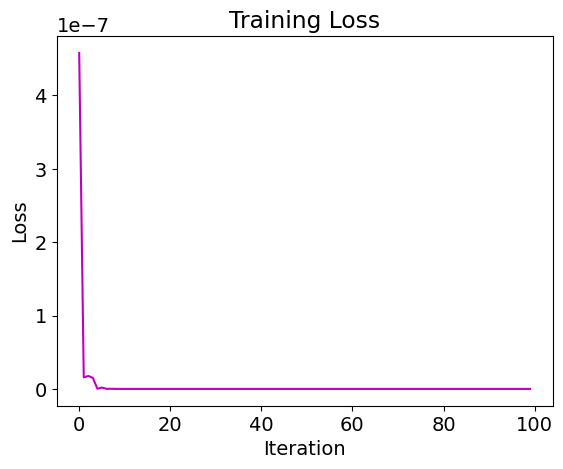

In [32]:
# Training loop
for iter in range(N_train):
    # clear gradients from previous step
    optimizer.zero_grad()  

    # compute output and loss
    Ain = sech_pulse(t, center, T0, A0)  # generate the input pulse
    Aout = forward(Ain)  # full forward pass
    
    loss = loss_function(Ain, Aout)  # calculate the loss

    # backpropagate the loss
    loss.backward()

    # print the gradient of T0# if gradient is nan break the loop
    if torch.isnan(A0.grad):
        print("Gradient is NaN. Exiting the loop.")
        break
    
    # update the parameters
    optimizer.step()

    # save and print the loss every 100 iteration
    if iter % 10 == 0:
        losses.append(loss.item())
        print(f"Iteration {iter}, Loss: {loss.item()}")

# plot the loss
plt.plot(losses, color='m')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

Show results

In [33]:
print("The optimal value of A0 would be:", A0.item())

The optimal value of A0 would be: 0.10003839433193207


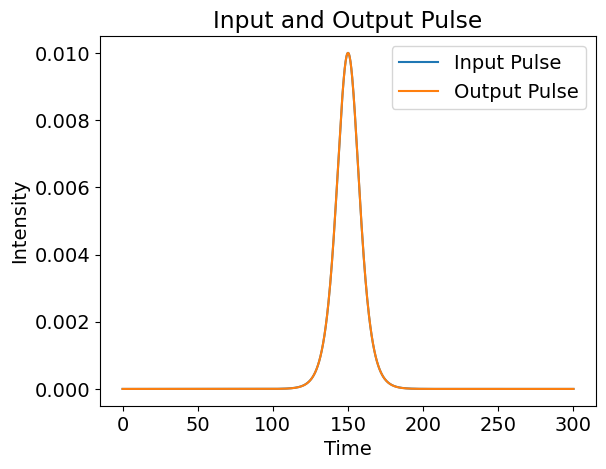

In [34]:
# Compute the sech_pulse output
pulse = sech_pulse(t, center, T0, A0.item())
out = forward(pulse)

# plit input pulse and output
plt.plot(t.detach().numpy(), (torch.abs(pulse)**2).detach().numpy(), label='Input Pulse')
plt.plot(t.detach().numpy(), (torch.abs(out)**2).detach().numpy(), label='Output Pulse')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.title('Input and Output Pulse')
plt.show()

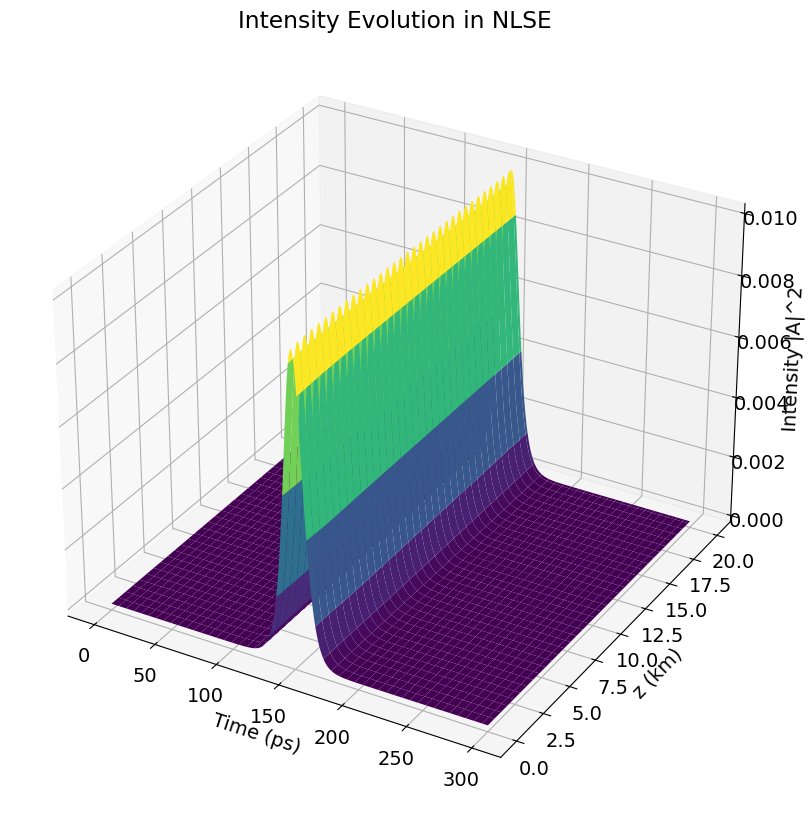

In [35]:
# plot the evolution of optimized input pulse
pulse = sech_pulse(t, center, T0, A0)

simulate_and_plot(pulse, dz, Nz, beta2, gamma, Lt)

Show Loss Space

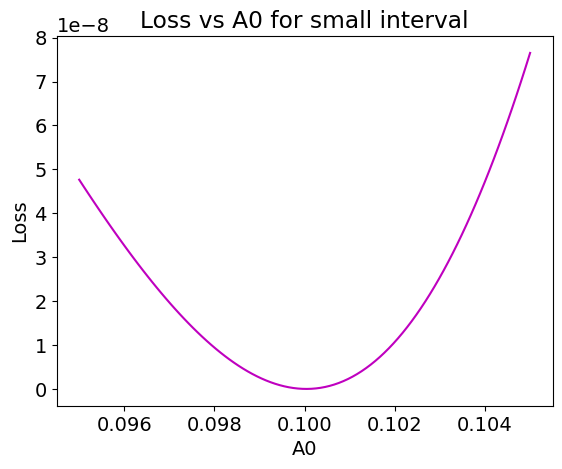

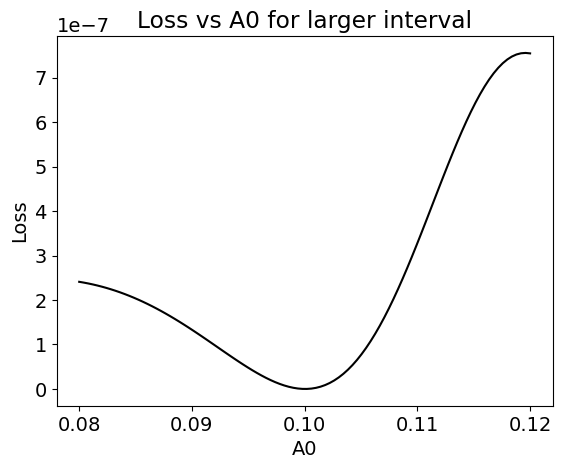

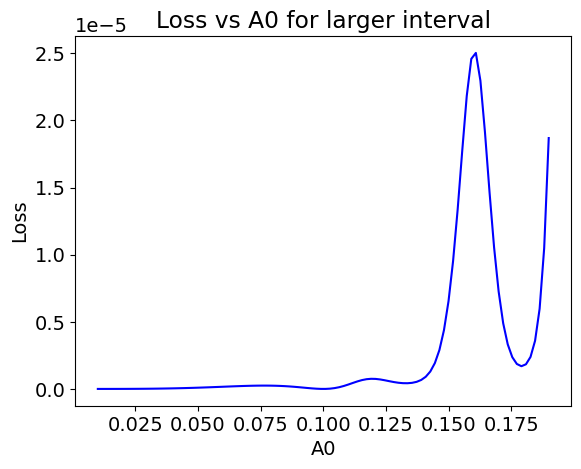

In [36]:

a0 = torch.linspace(0.095, 0.105, 100)
losses = []

for A0 in a0:
    out = forward(sech_pulse(t, center, T0, A0))
    loss = loss_function(sech_pulse(t, center, T0, A0), out)
    losses.append(loss.item())

plt.plot(a0, losses, color='m')
plt.xlabel('A0')
plt.ylabel('Loss')
plt.title('Loss vs A0 for small interval')
plt.show()


a0 = torch.linspace(0.080, 0.120, 100)
losses = []

for A0 in a0:
    out = forward(sech_pulse(t, center, T0, A0))
    loss = loss_function(sech_pulse(t, center, T0, A0), out)
    losses.append(loss.item())


plt.plot(a0, losses, color='k')
plt.xlabel('A0')
plt.ylabel('Loss')
plt.title('Loss vs A0 for larger interval')
plt.show()


a0 = torch.linspace(0.010, 0.190, 100)
losses = []

for A0 in a0:
    out = forward(sech_pulse(t, center, T0, A0))
    loss = loss_function(sech_pulse(t, center, T0, A0), out)
    losses.append(loss.item())


plt.plot(a0, losses, color='b')
plt.xlabel('A0')
plt.ylabel('Loss')
plt.title('Loss vs A0 for larger interval')
plt.show()



### Scenario 3: Optimizing $T_0$ and $A_0$ Parameters for sech() Pulse

Fundamental soliton pulse has the sech shape
\begin{equation}
    A_s(z,t) = A_0 sech( \frac{t}{T_0} ) e^{-i\frac{\beta_2}{2T_0^2} z}.
\end{equation}

In order to have a soliton, we need to ensure the effects from nonlinear term and the dispersion term balance out exactly, satisfying
\begin{equation}
    \gamma = - \frac{\beta_2}{T_0^2 A_0^2}.
\end{equation}

Keeping $\gamma$, $\beta_t$ constant we then expect the optimal parameter values to follow the relation
\begin{equation}
    A_0 T_0 = \sqrt{-\frac{\beta_2}{\gamma}}.
\end{equation}


In [7]:
# define pulse
def sech_pulse(t, center, T0, A0):
    """Generate a Gaussian pulse."""
    
    return A0* 1/torch.cosh( (t-center)/ T0 + 1e-16) + 1e-16

# define simulation parameters
Lz = 20.0               # Propagation distance in km
Nz = 100              # Number of steps in z
dz = 0.5 * Lz / Nz            # Step size in z
Lt = 300              # Temporal window size
Nt = 1024               # Number of temporal points
t = torch.linspace(0, Lt, Nt, requires_grad=False)  # Temporal grid (only positive times)

# define pulse parameters
center = Lt / 2         # Center of the Gaussian pulse
T0 = torch.tensor(11.0, requires_grad=True)            # Width of the Gaussian pulse on ps
A0 = torch.tensor(0.107, requires_grad=True)                # sqrt of the peak power of the Gaussian pulse

# define medium parameters
beta2 = -20           # Dispersion coefficient in ps^2/km
gamma = 20

print("The optimal value of A0*T0 would be:", np.sqrt(-(beta2)/(gamma)))

The optimal value of A0*T0 would be: 1.0


In [8]:
def forward(Ain):
    # Perform the split-step Fourier method
    A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)
    return A_evolution[:, -1]

def loss_function(Ain, Aout):
    # return the mean squared error
    return F.mse_loss(torch.abs(Ain)**2, torch.abs(Aout)**2)

optimizer = optim.Adam([A0, T0], lr=1e-4)

In [9]:
N_train = 1000

# define list to store losses
losses = []

Debugging

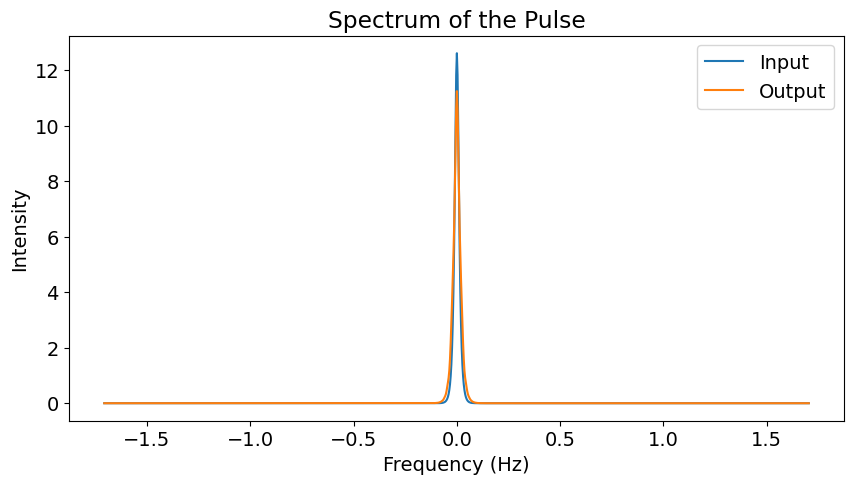

In [25]:
# Generate the pulse
pulse = sech_pulse(t, center, T0, A0)

# generate output pulse
out = forward(pulse)

plot_spectrum_comparison(pulse, out, Nt, Lt)



In [10]:
N_train = 1000

# define list to store losses
losses = []

Iteration 0, Loss: 9.13955545911449e-07
Iteration 10, Loss: 8.144933758558182e-07
Iteration 20, Loss: 7.120899567780725e-07
Iteration 30, Loss: 6.106157570684445e-07
Iteration 40, Loss: 5.141245082995738e-07
Iteration 50, Loss: 4.260364221408963e-07
Iteration 60, Loss: 3.485358490706858e-07
Iteration 70, Loss: 2.824284592861659e-07
Iteration 80, Loss: 2.2741312477592146e-07
Iteration 90, Loss: 1.8245367527924827e-07
Iteration 100, Loss: 1.4616557564295363e-07
Iteration 110, Loss: 1.1710486091942585e-07
Iteration 120, Loss: 9.393298228133062e-08
Iteration 130, Loss: 7.548118929889824e-08
Iteration 140, Loss: 6.07833570143157e-08
Iteration 150, Loss: 4.9057593543011535e-08
Iteration 160, Loss: 3.967934958382102e-08
Iteration 170, Loss: 3.215871302586493e-08
Iteration 180, Loss: 2.6110328121831117e-08
Iteration 190, Loss: 2.123422504496375e-08
Iteration 200, Loss: 1.7290320286633687e-08
Iteration 210, Loss: 1.4093794575842367e-08
Iteration 220, Loss: 1.1497203189492211e-08
Iteration 230, 

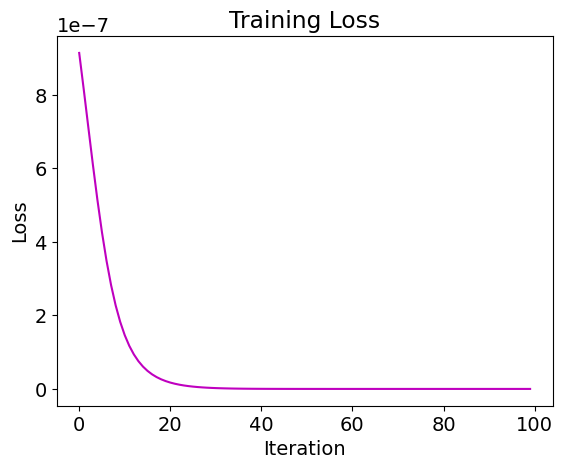

In [69]:
# Training loop
for iter in range(N_train):
    # clear gradients from previous step
    optimizer.zero_grad()  

    # compute output and loss
    Ain = sech_pulse(t, center, T0, A0)  # generate the input pulse
    Aout = forward(Ain)  # full forward pass
    
    loss = loss_function(Ain, Aout)  # calculate the loss

    # backpropagate the loss
    loss.backward()

    # print the gradient of T0# if gradient is nan break the loop
    if torch.isnan(A0.grad) or torch.isnan(T0.grad):
        print("Gradient is NaN. Exiting the loop.")
        break
    
    # update the parameters
    optimizer.step()

    # save and print the loss every 100 iteration
    if iter % 10 == 0:
        losses.append(loss.item())
        print(f"Iteration {iter}, Loss: {loss.item()}")

# plot the loss
plt.plot(losses, color='m')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

Show Results

In [70]:
print("The optimal value of A0 would be:", A0.item())
print("The optimal value of T0 would be:", T0.item())
# print product
print("The optimal value of A0*T0 would be:", A0.item()*T0.item())

The optimal value of A0 would be: 0.09100422263145447
The optimal value of T0 would be: 10.985054016113281
The optimal value of A0*T0 would be: 0.9996863013009261


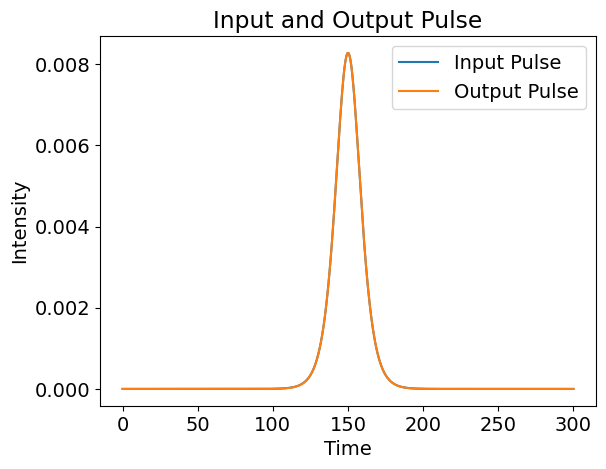

In [71]:
# plot output pulse for optimal A0 and T0
pulse = sech_pulse(t, center, T0, A0)
out = forward(pulse)

# plit input pulse and output
plt.plot(t.detach().numpy(), (torch.abs(pulse)**2).detach().numpy(), label='Input Pulse')
plt.plot(t.detach().numpy(), (torch.abs(out)**2).detach().numpy(), label='Output Pulse')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.title('Input and Output Pulse')
plt.show()



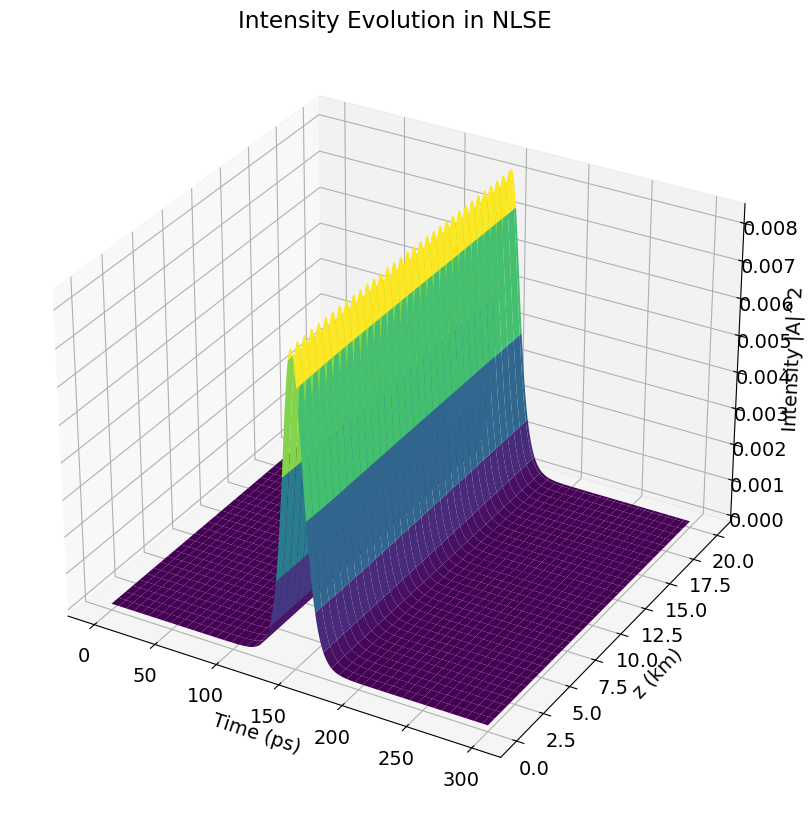

In [76]:
# plot the evolution of optimized input pulse
pulse = sech_pulse(t, center, T0, A0)

simulate_and_plot(pulse, dz, Nz, beta2, gamma, Lt)

Show Loss Space

In [72]:
# plot 3D loss function with respect to A0 and T0
a0 = torch.linspace(0.070, 0.130, 30)
t0 = torch.linspace(7, 13, 30)
losses = torch.zeros((30, 30))

for i, A in enumerate(a0):
    for j, T in enumerate(t0):
        out = forward(sech_pulse(t, center, T, A))
        loss = loss_function(sech_pulse(t, center, T, A), out)
        losses[i, j] = loss

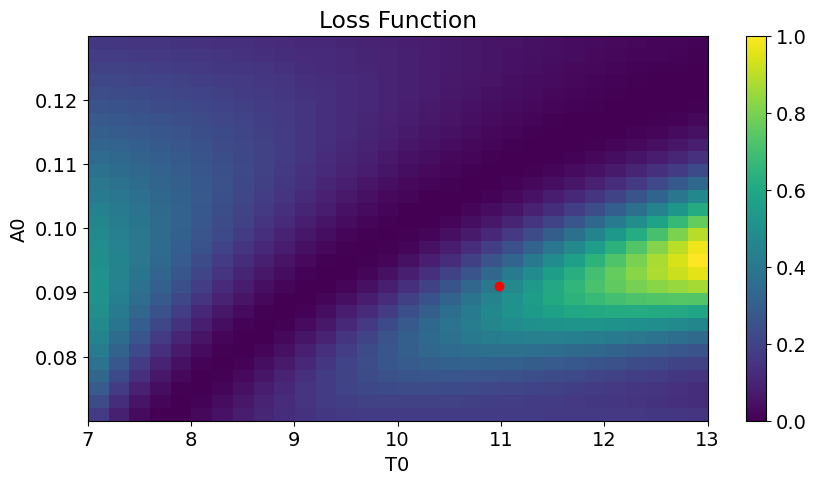

In [ ]:
# plot the loss
plt.figure(figsize=(10, 5))
plt.imshow(losses.detach().numpy(), extent=[t0[0], t0[-1], a0[0], a0[-1]], aspect='auto')
# plot the determined values
plt.scatter([T0.item()], [A0.item()], color='r')
plt.colorbar()
plt.xlabel('T0')
plt.ylabel('A0')
plt.title('Loss Function')
plt.show()

In [74]:
# plot 3D loss function with respect to A0 and T0
a0 = torch.linspace(A0.item()-0.01, A0+0.01, 30)
t0 = torch.linspace(T0.item()-1, T0.item()+1, 30)
losses = torch.zeros((30, 30))

for i, A in enumerate(a0):
    for j, T in enumerate(t0):
        out = forward(sech_pulse(t, center, T, A))
        loss = loss_function(sech_pulse(t, center, T, A), out)
        losses[i, j] = loss

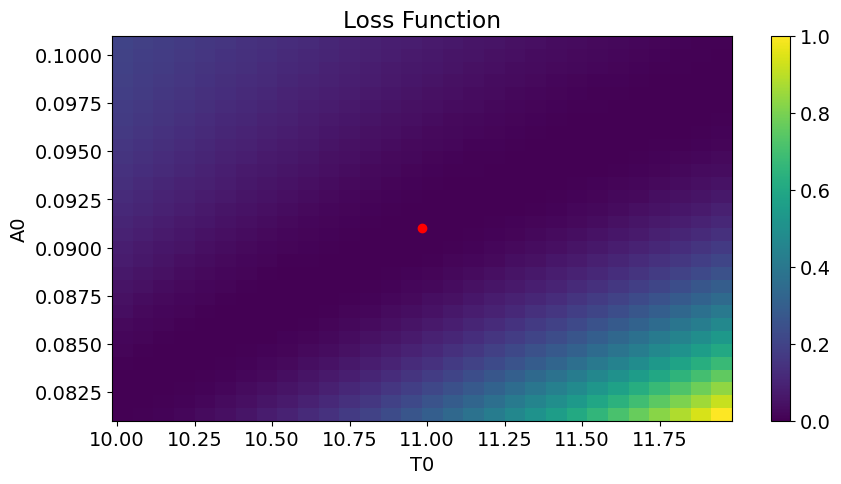

In [75]:
# plot the loss
plt.figure(figsize=(10, 5))
plt.imshow(losses.detach().numpy(), extent=[t0[0], t0[-1], a0[0], a0[-1]], aspect='auto')
# plot the determined values
plt.scatter([T0.item()], [A0.item()], color='r')
plt.colorbar()
plt.xlabel('T0')
plt.ylabel('A0')
plt.title('Loss Function')
plt.show()

### Scenario 4: Optimizing $A(0, t)$

Fundamental soliton pulse has the sech shape
\begin{equation}
    A_s(z,t) = A_0 sech( \frac{t}{T_0} ) e^{-i\frac{\beta_2}{2T_0^2} z}.
\end{equation}

This is the "optimal" pulse for the given medium

In [120]:
def gaussian_pulse(t, center, T0, P0):
    """Generate a Gaussian pulse using PyTorch."""
    return torch.sqrt(torch.tensor(P0)) * torch.exp(-((t - center) ** 2) / (2 * T0 ** 2))

In [121]:
# define simulation parameters
Lz = 20.0               # Propagation distance in km
Nz = 100              # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 300              # Temporal window size
Nt = 1024               # Number of temporal points

# instead of defining pulse parameters - define pulse itself - we take the initial pulse to be a Gaussian
center = Lt / 2         # Center of the Gaussian pulse
T0 = 10.0             # Width of the Gaussian pulse on ps
P0 = 0.007                # sqrt of the peak power of the Gaussian pulse
# independent variable (we use torch for automatic differentiation)
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)

Ain = torch.nn.Parameter(gaussian_pulse(t, center, T0, P0).clone().detach().requires_grad_(True))

# define medium parameters
beta2 = -20           # Dispersion coefficient in ps^2/km
gamma = 20

# optimal sech pulse would have
A0 = 0.1
T0 = 10


In [122]:
# loss weighting
w_mse = 1.0
w_smooth = 10

In [123]:
def forward(Ain):
    # Perform the split-step Fourier method
    A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)
    return A_evolution[:, -1]

def loss_function(Ain, Aout):
    # return the mean squared error
    mse_loss = F.mse_loss(torch.abs(Ain)**2, torch.abs(Aout)**2)
    smoothing_loss = time_derivative_fft(Ain, Nt, Lt).pow(2).mean()
    
    return w_mse * mse_loss + w_smooth * smoothing_loss

optimizer = optim.Adam([Ain], lr=1e-4)

In [124]:
N_train = 1000

# define list to store losses
losses = []

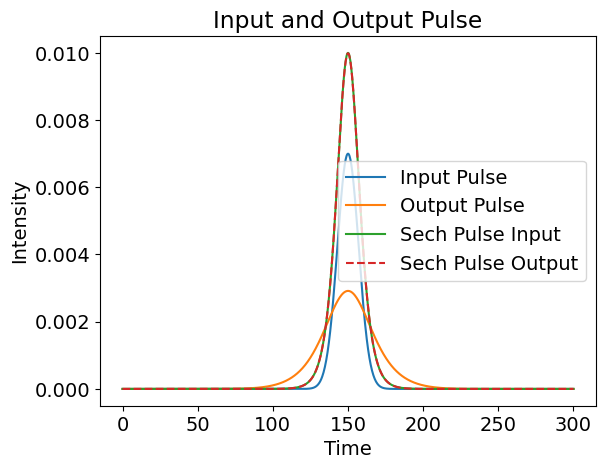

In [125]:
test = sech_pulse(t, center, T0, A0)
testout = forward(test)

out = forward(Ain)

# plit input pulse and output
plt.plot(t.detach().numpy(), (torch.abs(Ain)**2).detach().numpy(), label='Input Pulse')
plt.plot(t.detach().numpy(), (torch.abs(out)**2).detach().numpy(), label='Output Pulse')
plt.plot(t.detach().numpy(), (torch.abs(test)**2).detach().numpy(), label='Sech Pulse Input')
plt.plot(t.detach().numpy(), (torch.abs(testout)**2).detach().numpy(), label='Sech Pulse Output', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.title('Input and Output Pulse')
plt.show()




# # Compute the derivative of the sum of the output w.r.t. T0
# pulse.sum().backward()  # Backpropagate the gradient
# print(f"Derivative of sech_pulse w.r.t. T0: {T0.grad}")

# # plot the pulse
# plt.plot(t.detach().numpy(), pulse.detach().numpy())
# plt.xlabel('Time')
# plt.ylabel('Intensity')
# plt.title('Sech Pulse')
# plt.show()


Iteration 0, Loss: 2.1359746824600734e-05
Iteration 10, Loss: 2.101438985846471e-05
Iteration 20, Loss: 2.1711590306949802e-05
Iteration 30, Loss: 2.289804251631722e-05
Iteration 40, Loss: 2.4135897547239438e-05
Iteration 50, Loss: 2.5135866962955333e-05
Iteration 60, Loss: 2.5747845938894898e-05
Iteration 70, Loss: 2.5967974579543807e-05
Iteration 80, Loss: 2.5917961465893313e-05
Iteration 90, Loss: 2.5745772290974855e-05
Iteration 100, Loss: 2.5555376851116307e-05
Iteration 110, Loss: 2.5400151571375318e-05
Iteration 120, Loss: 2.530185884097591e-05
Iteration 130, Loss: 2.5266561351600103e-05
Iteration 140, Loss: 2.5292361897299998e-05
Iteration 150, Loss: 2.537247746658977e-05
Iteration 160, Loss: 2.5497309252386913e-05
Iteration 170, Loss: 2.5656450816313736e-05
Iteration 180, Loss: 2.5840347007033415e-05
Iteration 190, Loss: 2.6041172532131895e-05
Iteration 200, Loss: 2.6253042960888706e-05
Iteration 210, Loss: 2.6471801902516745e-05
Iteration 220, Loss: 2.669470450200606e-05
Iter

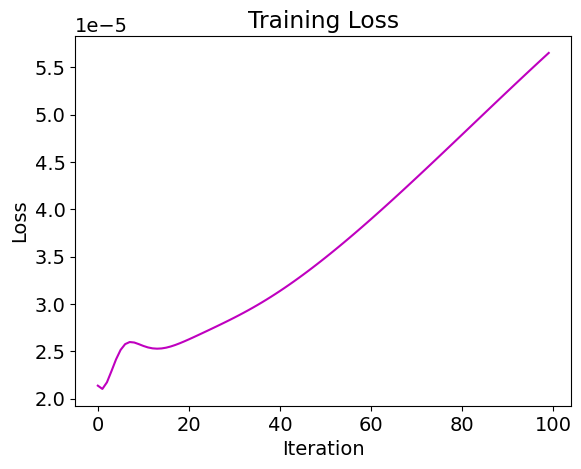

In [126]:
# Training loop
for iter in range(N_train):
    # clear gradients from previous step
    optimizer.zero_grad()  

    Aout = forward(Ain)  # full forward pass
    
    loss = loss_function(Ain, Aout)  # calculate the loss

    # backpropagate the loss
    loss.backward()
    
    # update the parameters
    optimizer.step()

    # save and print the loss every 100 iteration
    if iter % 10 == 0:
        losses.append(loss.item())
        print(f"Iteration {iter}, Loss: {loss.item()}")

# plot the loss
plt.plot(losses, color='m')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

Show Results

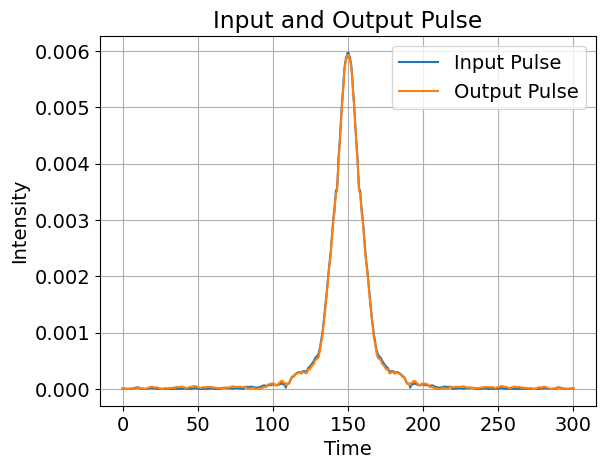

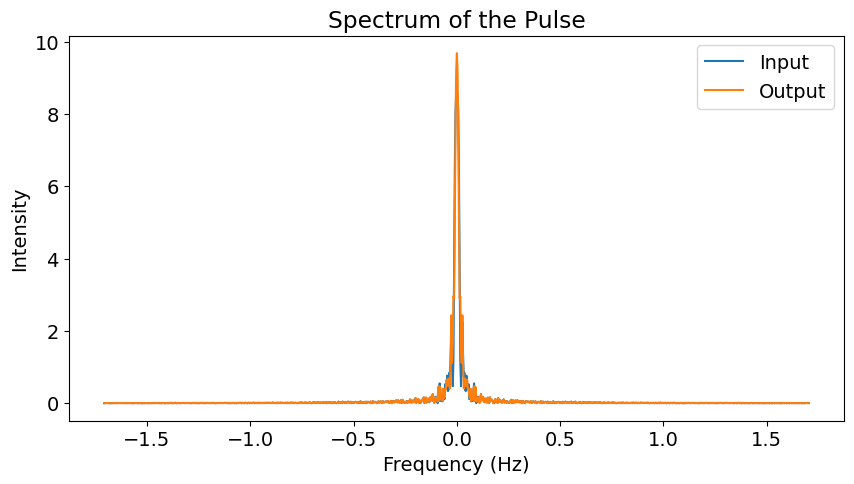

In [127]:
# plot determined optimal pulse
out = forward(Ain)


# plit input pulse and output
plt.plot(t.detach().numpy(), (torch.abs(Ain)**2).detach().numpy(), label='Input Pulse')
plt.plot(t.detach().numpy(), (torch.abs(out)**2).detach().numpy(), label='Output Pulse')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.grid()
plt.title('Input and Output Pulse')
plt.show()

# plot input output spectrum comparison
plot_spectrum_comparison(Ain, out, Nt, Lt)


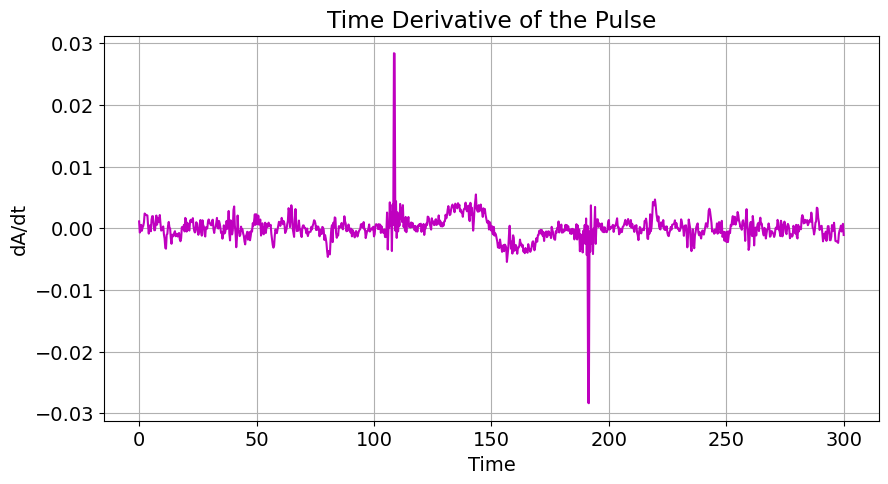

In [128]:
plot_time_derivative(Ain, Nt, Lt)

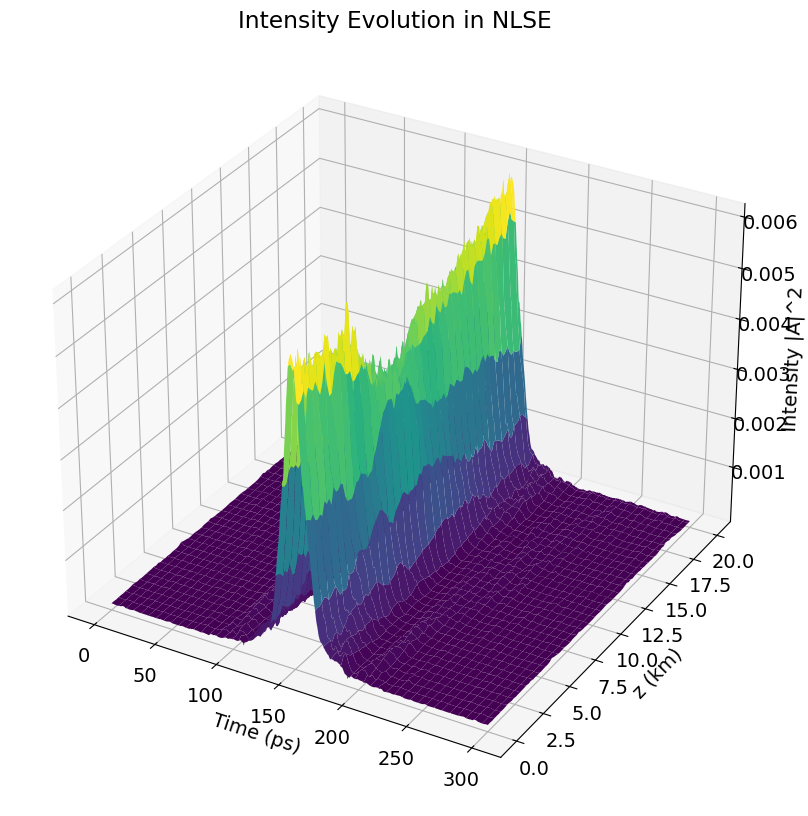

In [129]:
# plot the evolution of optimized input pulse
simulate_and_plot(Ain, dz, Nz, beta2, gamma, Lt)

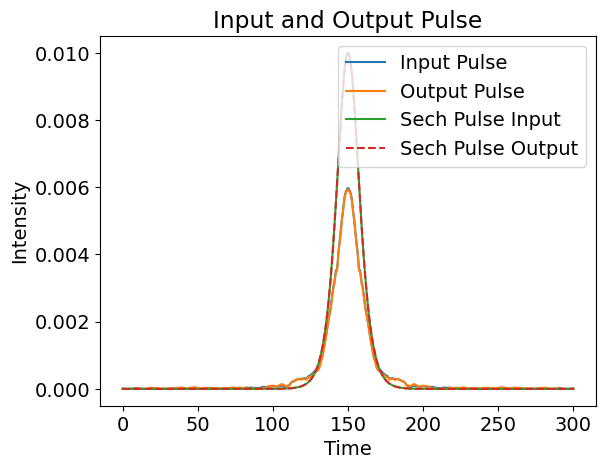

In [86]:
test = sech_pulse(t, center, T0, A0)
testout = forward(test)

out = forward(Ain)

# plit input pulse and output
plt.plot(t.detach().numpy(), (torch.abs(Ain)**2).detach().numpy(), label='Input Pulse')
plt.plot(t.detach().numpy(), (torch.abs(out)**2).detach().numpy(), label='Output Pulse')
plt.plot(t.detach().numpy(), (torch.abs(test)**2).detach().numpy(), label='Sech Pulse Input')
plt.plot(t.detach().numpy(), (torch.abs(testout)**2).detach().numpy(), label='Sech Pulse Output', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.title('Input and Output Pulse')
plt.show()

## Lessons Learned

1. If we have too small of values somewhere in our calculations (for example if we look at the pulse very far away from the peak) the float or even double datatypes might "underflow" and set the value to 0 at that point from which it is not possible to compute the gradient and therefore the gradient w.r.t the parameter becomes NaN.
2. Loss space can have unwanted local minima - might be a good idea to try various random initial parameter values and also consider bounding initial parameter values